In [24]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
data = pd.read_csv("~/Downloads/counts_tr_annotations_vinter.bed.gz", 
                   sep='\t', names=["chrom", "start", "end", "period", "copies", "score", "entropy", "repeat", "var_count", "var_bases"])


In [3]:
data.shape

(2337945, 10)

In [4]:
data.head()

,chrom,start,end,period,copies,score,entropy,repeat,var_count,var_bases
0,chr1,16712,16743,3,10.7,56,0.95,TGG,12,20
1,chr1,16713,16738,1,26.0,28,0.85,G,8,8
2,chr1,16712,16743,9,3.6,69,0.95,TGGTGGGGG,12,20
3,chr1,19278,19286,4,2.2,27,1.53,CGAG,6,6
4,chr1,19335,19353,3,6.3,30,1.17,GAG,10,10


In [7]:
data['has_nonsnp'] = (data['var_count'] > 0) & (data['var_count'] != data['var_bases'])

<AxesSubplot:xlabel='entropy', ylabel='Density'>

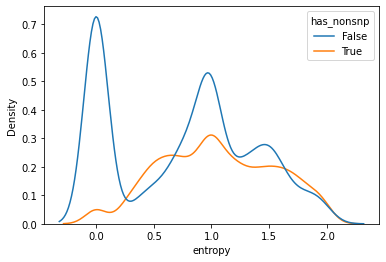

In [8]:
sb.kdeplot(data=data.sample(10000), x="entropy", hue="has_nonsnp")

[(0.0, 1000.0)]

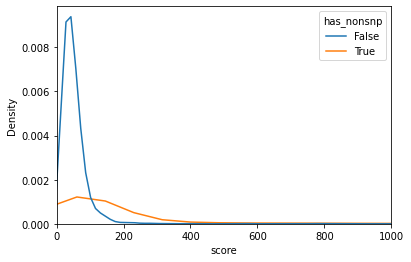

In [12]:
sb.kdeplot(data=data.sample(10000), x="score", hue="has_nonsnp").set(xlim=(0, 1000))

In [17]:
data[~data['has_nonsnp'] & (data['score'] < 40)].shape

(683158, 11)

In [14]:
data.shape

(2337945, 11)

In [16]:
73792 / 2337945 

0.03156276131388891

In [18]:
683158 / 2337945 # 30% are low-score and have no non-snp

0.2922044787195593

In [19]:
# But because I know realignment will shift where variants hit.. I need to do realignment first.

In [20]:
data.head()

,chrom,start,end,period,copies,score,entropy,repeat,var_count,var_bases,has_nonsnp
0,chr1,16712,16743,3,10.7,56,0.95,TGG,12,20,True
1,chr1,16713,16738,1,26.0,28,0.85,G,8,8,False
2,chr1,16712,16743,9,3.6,69,0.95,TGGTGGGGG,12,20,True
3,chr1,19278,19286,4,2.2,27,1.53,CGAG,6,6,False
4,chr1,19335,19353,3,6.3,30,1.17,GAG,10,10,False


In [34]:
import numpy as np
class kmer_featurization:
    
    def __init__(self, k):
        """
        seqs: a list of DNA sequences
        k: the "k" in k-mer
        """
        self.k = k
        self.letters = ['A', 'T', 'C', 'G']
        self.multiplyBy = 4 ** np.arange(k-1, -1, -1) # the multiplying number for each digit position in the k-number system
        self.n = 4**k # number of possible k-mers
    
    def encode_list(self, seqs, write_number_of_occurences=False):
        return self.obtain_kmer_feature_for_a_list_of_sequences(seqs, write_number_of_occurences)
    
    def obtain_kmer_feature_for_a_list_of_sequences(self, seqs, write_number_of_occurrences=False):
        """
        Given a list of m DNA sequences, return a 2-d array with shape (m, 4**k) for the 1-hot representation of the kmer features.

        Args:
          write_number_of_occurrences:
            a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.    
        """
        kmer_features = []
        for seq in seqs:
            this_kmer_feature = self.obtain_kmer_feature_for_one_sequence(seq.upper(), write_number_of_occurrences=write_number_of_occurrences)
            kmer_features.append(this_kmer_feature)

        kmer_features = np.array(kmer_features)

        return kmer_features

    def encode(self, seqs, write_number_of_occurences=False):
        return self.obtain_kmer_feature_for_one_sequence(seqs, write_number_of_occurences)

    def obtain_kmer_feature_for_one_sequence(self, seq, write_number_of_occurrences=False):
        """
        Given a DNA sequence, return the 1-hot representation of its kmer feature.

        Args:
          seq: 
            a string, a DNA sequence
          write_number_of_occurrences:
            a boolean. If False, then in the 1-hot representation, the percentage of the occurrence of a kmer will be recorded; otherwise the number of occurrences will be recorded. Default False.
        """
        number_of_kmers = len(seq) - self.k + 1

        kmer_feature = np.zeros(self.n)

        for i in range(number_of_kmers):
            this_kmer = seq[i:(i+self.k)]
            this_numbering = self.kmer_numbering_for_one_kmer(this_kmer)
            kmer_feature[this_numbering] += 1

        if not write_number_of_occurrences:
            kmer_feature = kmer_feature / number_of_kmers

        return kmer_feature

    def kmer_numbering_for_one_kmer(self, kmer):
        """
        Given a k-mer, return its numbering (the 0-based position in 1-hot representation)
        """
        digits = []
        for letter in kmer:
            digits.append(self.letters.index(letter))

        digits = np.array(digits)

        numbering = (digits * self.multiplyBy).sum()

        return numbering


In [38]:
two_merizer = kmer_featurization(2)
twos = two_merizer.encode_list(data["repeat"])
three_merizer = kmer_featurization(3)
threes = three_merizer.encode_list(data["repeat"])

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_36547/1639520529.py:57: RuntimeWarning: invalid value encountered in divide
  kmer_feature = kmer_feature / number_of_kmers


In [43]:
three_merizer = kmer_featurization(3)
threes = three_merizer.encode_list(data["repeat"])

/var/folders/fy/lkd5_yz90zq3f67qys3tpztc0000gn/T/ipykernel_36547/1639520529.py:57: RuntimeWarning: invalid value encountered in divide
  kmer_feature = kmer_feature / number_of_kmers


In [44]:
twos.shape

(2337945, 16)

In [45]:
threes.shape

(2337945, 64)

In [47]:
a = np.random.random((5, 6))
b = np.random.random((5, 12))


In [50]:
full_1hot = np.hstack([twos, threes])

In [51]:
full_1hot.shape

(2337945, 80)

In [52]:
r_dat = data[['period', 'copies', 'score', 'entropy', 'var_count', 'var_bases']].values

In [53]:
full_train = np.hstack([r_dat, full_1hot])

In [55]:
import joblib
joblib.dump(full_train, "full_train.jl")

['full_train.jl']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [80]:
from sklearn.feature_selection import VarianceThreshold

In [81]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))

In [82]:
sel_train = sel.fit_transform(full_train)

In [92]:
dir(sel)
#sel.variances_
sel.variances_ > sel.threshold

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [102]:
full_train = joblib.load("full_train.jl")[:, :6]
from minisom import MiniSom    
som = MiniSom(12, 12, 6, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som.train(full_train, 100) # trains the SOM with N iterations

In [103]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in full_train]).T
# with np.ravel_multi_index we convert the bidimensional
cluster_index = np.ravel_multi_index(winner_coordinates, full_train.shape)

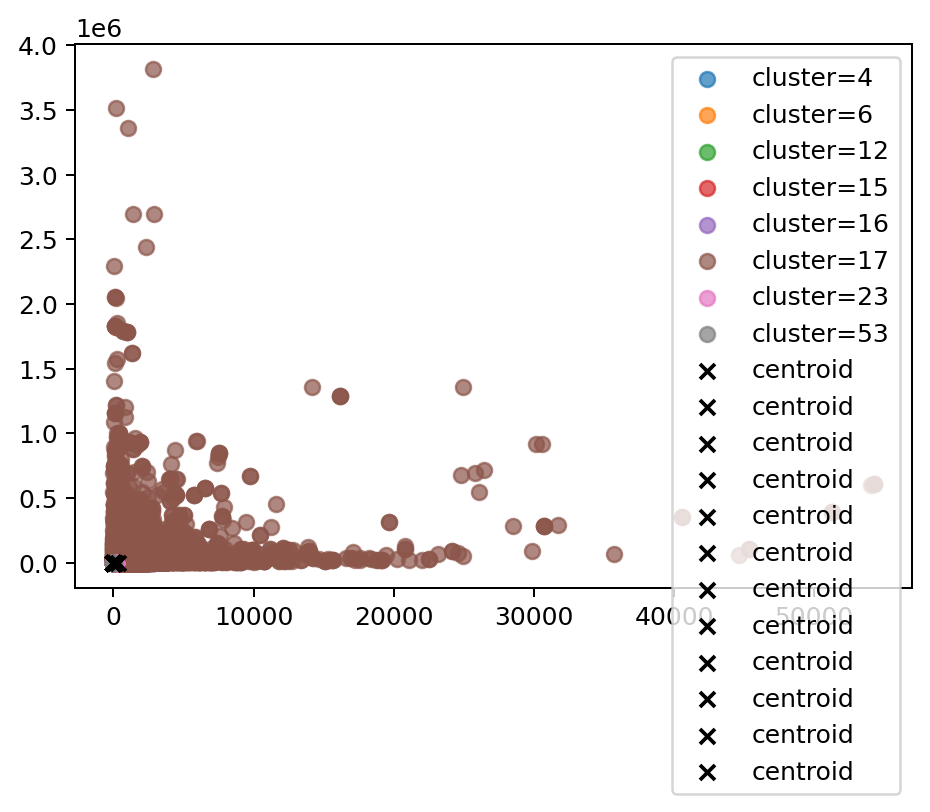

In [105]:
%matplotlib inline

plt.figure(dpi=180)
x = 4
y = 5
# plotting the clusters using the first x/y dimensions of the data
for c in np.unique(cluster_index):
    plt.scatter(full_train[cluster_index == c, x],
                full_train[cluster_index == c, y], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, x], centroid[:, y], marker='x', 
                 color='k', label='centroid') #s=80, linewidths=35,
plt.legend();

In [72]:
winner_coordinates.mean(axis=0).max()

0.0

In [106]:
cluster_index.shape

(2337945,)

In [107]:
data.shape

(2337945, 11)

In [108]:
data['cluster'] = cluster_index

In [109]:
data.head()

,chrom,start,end,period,copies,score,entropy,repeat,var_count,var_bases,has_nonsnp,cluster
0,chr1,16712,16743,3,10.7,56,0.95,TGG,12,20,True,23
1,chr1,16713,16738,1,26.0,28,0.85,G,8,8,False,12
2,chr1,16712,16743,9,3.6,69,0.95,TGGTGGGGG,12,20,True,23
3,chr1,19278,19286,4,2.2,27,1.53,CGAG,6,6,False,12
4,chr1,19335,19353,3,6.3,30,1.17,GAG,10,10,False,12


[None, None]

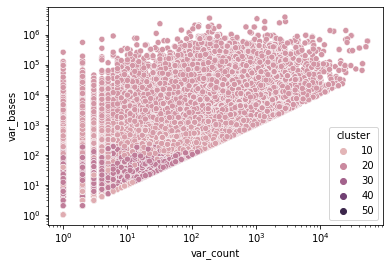

In [115]:
sb.scatterplot(data=data, x=data['var_count'], y=data["var_bases"], hue="cluster").set(xscale="log", yscale="log")